# Inspecting Data, Metrics and Calibration Solutions

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import numpy as np
import hera_qm as hqm
import hera_cal as hc
import aipy
from pyuvdata import UVCal, UVData, UVFITS
import os
import sys
import glob
from memory_profiler import memory_usage as memuse
import uvtools as uvt
from collections import OrderedDict
from astropy.time import Time
import pandas
import aipy.miriad as apm
import re
import copy

## Setup Env Vars


In [2]:
# get data location
data_path = os.environ['DATA_PATH']

In [3]:
# get xx and yy files
xxfiles = sorted(glob.glob("{0}/zen.*.*.xx.HH.uv".format(data_path)))
yyfiles = sorted(glob.glob("{0}/zen.*.*.yy.HH.uv".format(data_path)))
Nfiles = len(xxfiles)

xxfile_bases = map(os.path.basename, xxfiles)
yyfile_bases = map(os.path.basename, yyfiles)

xxfile_times = np.array(map(lambda x: '.'.join(os.path.basename(x).split('.')[1:3]), xxfiles), np.float)
yyfile_times = np.array(map(lambda y: '.'.join(os.path.basename(y).split('.')[1:3]), yyfiles), np.float)

# choose one for single-file plots
file_index = 20
xxfile = xxfiles[file_index]
yyfile = yyfiles[file_index]
xxfile_base = xxfile_bases[file_index]
yyfile_base = yyfile_bases[file_index]
file_jd = xxfile_times[file_index]

IndexError: list index out of range

In [4]:
# Load data
uvd_xx = UVData()
uvd_xx.read_miriad(xxfile)
uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
uvd_yy = UVData()
uvd_yy.read_miriad(yyfile)
uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

# Get metadata
freqs = uvd_xx.freq_array.squeeze() / 1e6
times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
jd_start = np.floor(times.min())
Nfreqs = len(freqs)
Ntimes = len(times)

# get redundant info
aa = hc.utils.get_aa_from_uv(uvd_xx)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())
ants = sorted(np.unique(np.concatenate(red_bls)))
Nants = len(ants)
Nside = int(np.ceil(np.sqrt(Nants)))
Yside = int(np.ceil(float(Nants)/Nside))

NameError: name 'xxfile' is not defined

## Autocorrelations

In [5]:
### plot autos
t_index = 0
jd = times[t_index]
utc = Time(jd, format='jd').datetime

xlim = (-50, Nfreqs+50)
ylim = (-10,30)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < Nants:
            px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
            py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
            ax.grid(True, which='both')
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['East', 'North'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=14)

        k += 1

NameError: name 'times' is not defined

### Plot auto amplitude at a specific frequency over entire night

In [6]:
def timeseries_data(files, nu_index=500):
    amps = []
    times = []
    print "gather nightly data for JD = {0}".format(jd_start)
    Nfiles = len(files)
    for i, fname in enumerate(files):
        uvd = apm.UV(fname)
        uvd.select('auto', -1, -1)
        Ntimes = uvd['ntimes']
        Nants = len(uvd['antnums'])
        Nfreqs = uvd['nchan']
        auto = []
        time = []
        for (uvw, t, (i, j)), d, f in uvd.all(raw=True):
            auto.append(np.abs(d))
            time.append(t)
        amps.extend(np.array(auto).reshape(Ntimes, Nants, Nfreqs)[:, :, nu_index])
        times.extend(np.array(time).reshape(Ntimes, Nants)[:, 0])
        del uvd
    return np.array(amps).T, np.array(times)

nu_index = 500
amps_timeseries_xx, times_xx = timeseries_data(xxfiles, nu_index=nu_index)
amps_timeseries_yy, times_yy = timeseries_data(yyfiles, nu_index=nu_index)
times_xx = times_xx % 1
times_yy = times_yy % 1

NameError: global name 'jd_start' is not defined

In [7]:
# plot autos
ylim = (0, np.median(np.abs(amps_timeseries_xx))*3)
ylim = (1e-1, np.abs(amps_timeseries_xx).max() * 3)

fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle("autocorrelation from {0} -- {1} at freq bin {2}".format(times[0], times[-1], nu_index), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_ylim(ylim)
        if k < Nants:
            ax.set_yscale('log')
            px, = ax.plot(times_xx, np.abs(amps_timeseries_xx[k]), color='steelblue', alpha=0.5, linewidth=3)
            py, = ax.plot(times_yy, np.abs(amps_timeseries_yy[k]), color='darkorange', alpha=0.5, linewidth=3)
            ax.grid(True)
            ax.set_title(str(ants[k]), fontsize=14)
            if k == 0:
                ax.legend([px, py], ['East', 'North'], fontsize=12)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_yticklabels()]
            ax.set_ylabel('amplitude', fontsize=14)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(12) for t in ax.get_xticklabels()]
            [t.set_rotation(25) for t in ax.get_xticklabels()]
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
            ax.set_xlabel('decimal of JD', fontsize=14)
        k += 1

NameError: name 'amps_timeseries_xx' is not defined

## Plot Ant Metrics

### Ant metrics for a single file

In [8]:
antfile = xxfile_base.split('.')
antfile.pop(3)
antfile = os.path.join(data_path, '.'.join(antfile) + '.ant_metrics.json')
ant_metrics = hqm.ant_metrics.load_antenna_metrics(antfile)

NameError: name 'xxfile_base' is not defined

In [9]:
def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    '''Helper function for quickly plotting an individual antenna metric.'''

    if ants is None:
        ants = list(set([key[0] for key in metrics.keys()]))
    if antpols is None:
        antpols = list(set([key[1] for key in metrics.keys()]))

    for antpol in antpols:
        for i,ant in enumerate(ants):
            metric = 0
            if metrics.has_key((ant,antpol)):
                metric = metrics[(ant,antpol)]
            plt.plot(i,metric,'.')
            if antpol == 'y':
                antpol_str = 'n'
            elif antpol == 'x':
                antpol_str = 'e'
            plt.annotate(str(ant)+antpol_str,xy=(i,metrics[(ant,antpol)]))
        plt.gca().set_prop_cycle(None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [10]:
print "Ant Metrics for {}".format(antfile)
plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVij'], 
            title = 'Mean Vij Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorr'],
            title = 'Redundant Visibility Correlation Modified z-Score')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
            title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()
plot_metric(ant_metrics['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')

NameError: name 'antfile' is not defined

### Ant Metrics `xants` over the entire observation

In [11]:
# append xants ant metrics over night
xants = np.zeros((Nants*2, Nfiles))
dead_ants = np.zeros((Nants*2, Nfiles))
cross_ants = np.zeros((Nants*2, Nfiles))
badants = []
pol2ind = {'x':0, 'y':1}

for i, fbase in enumerate(xxfile_bases):
    antfname = fbase.split('.')
    antfname.pop(3)
    antfname = os.path.join(data_path, '.'.join(antfname) + '.ant_metrics.json')
    try:
        antmets = hqm.ant_metrics.load_antenna_metrics(antfname)
        for j in antmets['xants']:
            xants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
        badants.extend(map(lambda x: x[0], antmets['xants']))
        for j in antmets['crossed_ants']:
            cross_ants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
        for j in antmets['dead_ants']:
            dead_ants[2*ants.index(j[0])+pol2ind[j[1]], i] = 1
    except:
        pass
    
badants = np.unique(badants)

xants[np.where(xants==1.0)] *= np.nan
dead_ants[np.where(dead_ants==0.0)] *= np.nan
cross_ants[np.where(cross_ants==0.0)] *= np.nan

NameError: name 'Nants' is not defined

NameError: name 'xants' is not defined

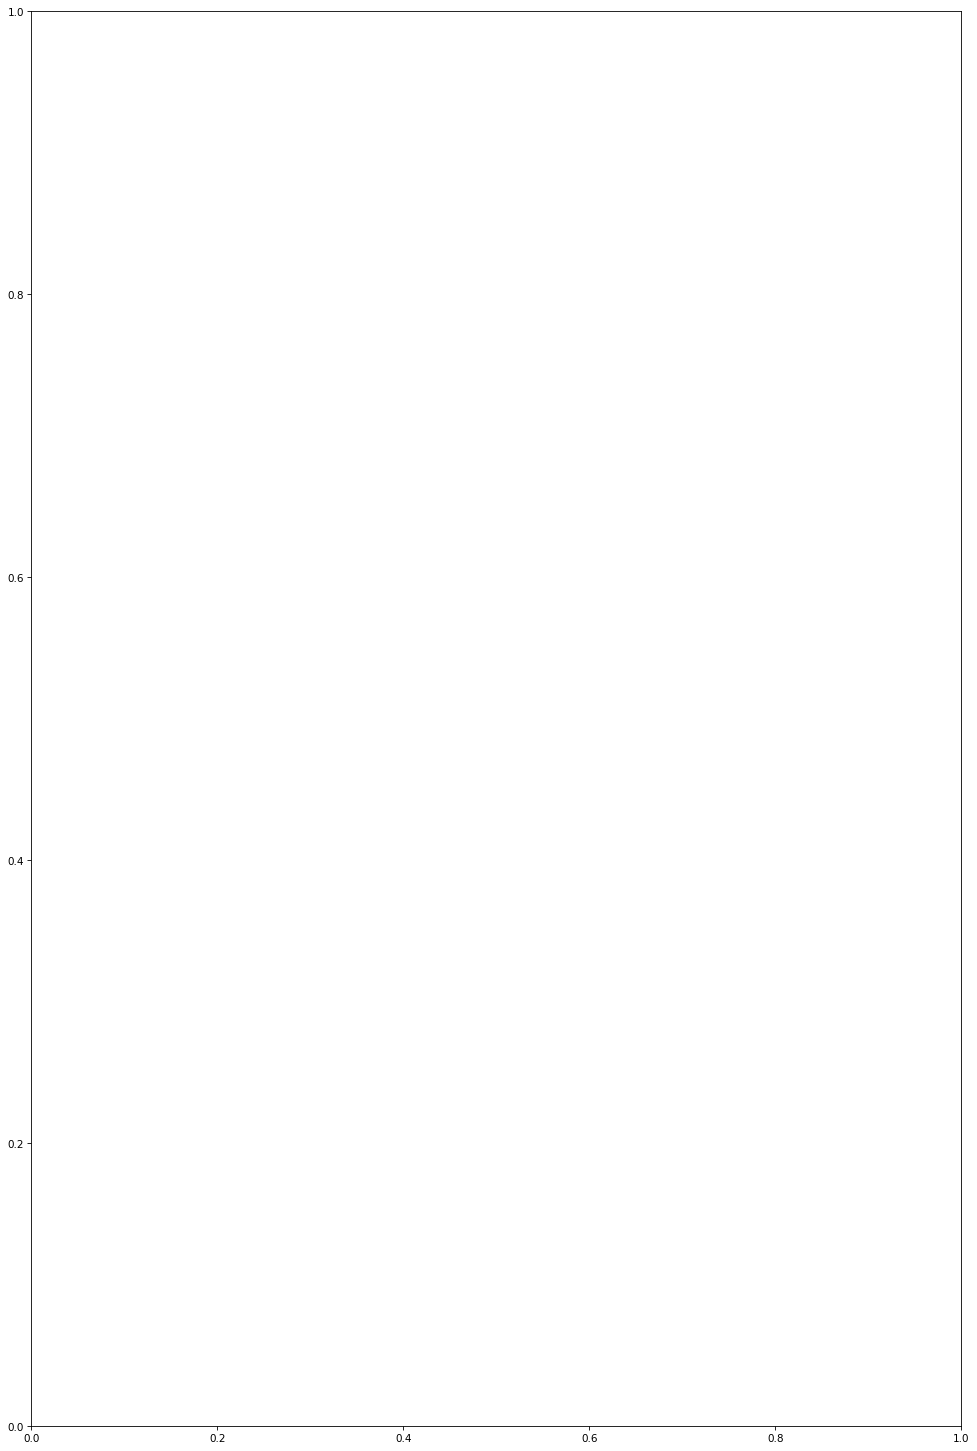

In [12]:
# figure
fig, ax = plt.subplots(1, figsize=(16,25), dpi=75)

# plotting
# plot xants
ax.matshow(xants, aspect='auto', cmap='RdYlGn_r', vmin=-.3, vmax=1.3,
           extent=[0, len(xxfile_times), Nants*2, 0])

# only plot if not completely masked
if np.isnan(dead_ants).min() == False:
    ax.matshow(dead_ants, aspect='auto', cmap='RdYlGn_r', vmin=-.3, vmax=1.3,
               extent=[0, len(xxfile_times), Nants*2, 0])
    
if np.isnan(cross_ants).min() == False:
    ax.matshow(cross_ants, aspect='auto', cmap='RdBu', vmin=-.3, vmax=1.3,
               extent=[0, len(xxfile_times), Nants*2, 0])

# axes
ax.grid(color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(len(xxfile_times))+0.5)
ax.set_yticks(np.arange(Nants*2)+0.5)
ax.tick_params(size=8)
if Nfiles > 20:
    ticklabels = np.around(xxfile_times % jd_start, 3).astype(str)
    ticklabels[::2] = ''
    ax.set_xticklabels(ticklabels)
else:
    ax.set_xticklabels(np.around(xxfile_times % jd_start, 3))
ax.set_yticklabels([''.join([str(a), p]) for a in ants for p in ['e', 'n']])

[t.set_rotation(30) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(0) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

ax.set_title("Ant Metrics bad ants over observation", fontsize=14)
ax.set_xlabel('decimal of JD = {}'.format(int(jd_start)), fontsize=16)
ax.set_ylabel('antenna number and pol', fontsize=16)
red_ptch = mpatches.Patch(color='red')
grn_ptch = mpatches.Patch(color='green')
blu_ptch = mpatches.Patch(color='blue')
ax.legend([red_ptch, blu_ptch, grn_ptch], ['dead ant', 'cross ant', 'good ant'], fontsize=14)

### Plot Ant Metrics over observation for specific antennas

In [13]:
# get ant metrics over night for specific antennas
ant_indices = np.where(np.sum(np.isnan(xants), axis=1) > 0)[0]

# append ant metrics over night
antpols = np.concatenate(map(lambda x: [str(x)+'e', str(x)+'n'], ants))[ant_indices]
ap_list = OrderedDict([(ap, []) for ap in antpols])
mets = {'meanVij':copy.deepcopy(ap_list), 'meanVijXPol':copy.deepcopy(ap_list), 'redCorr':copy.deepcopy(ap_list), 'redCorrXPol':copy.deepcopy(ap_list)}
tfiles = []
pol2ind = {'x':0, 'y':1}

for i, fbase in enumerate(xxfile_bases):
    antfname = fbase.split('.')
    antfname.pop(3)
    antfname = os.path.join(data_path, '.'.join(antfname) + '.ant_metrics.json')
    try:
        antmets = hqm.ant_metrics.load_antenna_metrics(antfname)['final_mod_z_scores']
        tfiles.append(float('.'.join(fbase.split('.')[1:3])))
        for am in antmets.keys():
            for ap in antpols:
                a,p = re.match(r"([0-9]+)([a-z]+)", ap, re.I).groups()
                mets[am][ap].append(antmets[am][(int(a), 'x' if p == 'e' else 'y')])
    except:
        pass
    
tfiles = np.array(tfiles) % np.floor(np.min(tfiles))

NameError: name 'xants' is not defined

NameError: name 'mets' is not defined

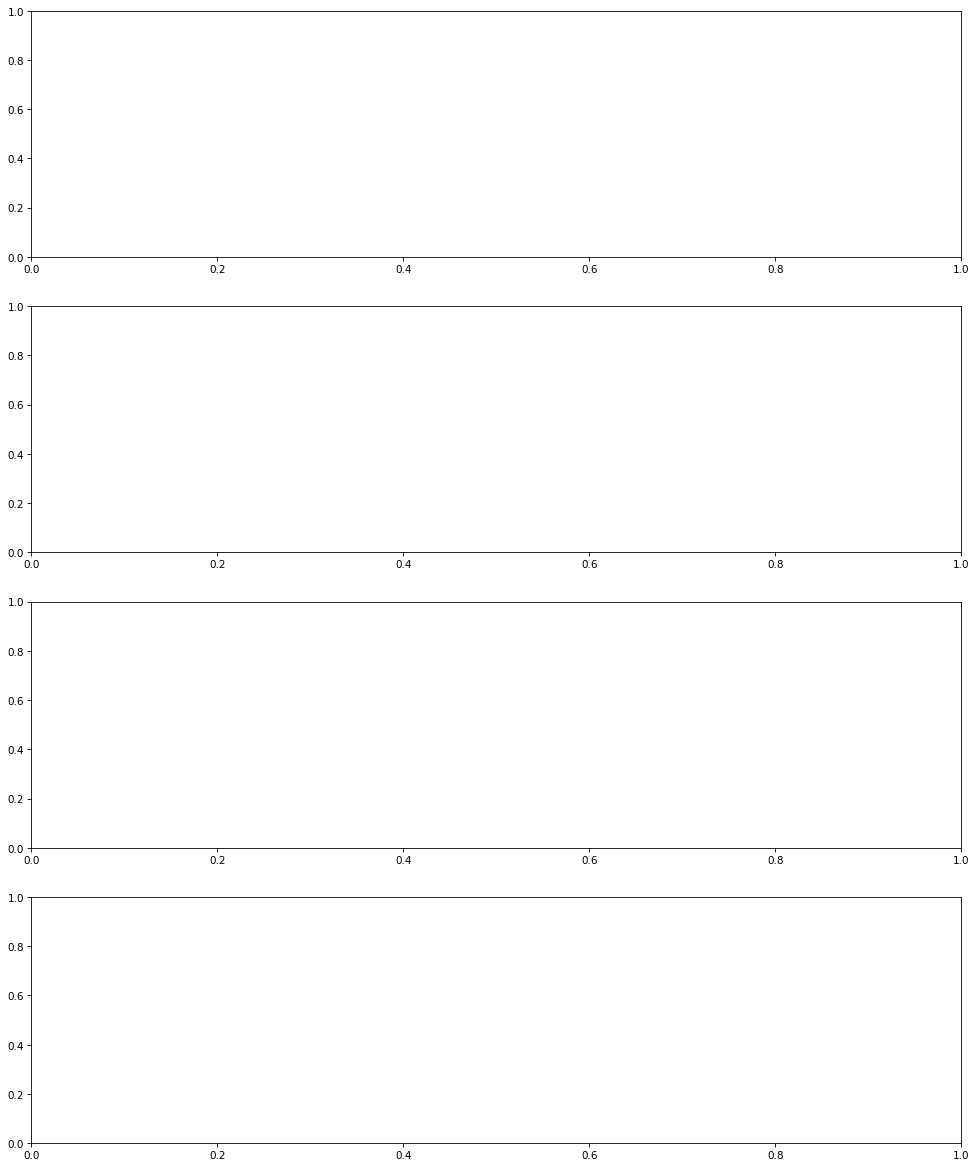

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(16,20), dpi=75)

for i, am in enumerate(mets.keys()):
    ax[i].grid(True)
    pl = np.concatenate([ax[i].plot(tfiles, mets[am][k], alpha=0.75, ms=5, marker='o') for k in mets[am].keys()])
    ax[i].legend(pl, mets[am].keys())
    ax[i].set_title(am)
    ax[i].set_ylabel('modified z-score', fontsize=12)

ax[-1].set_xlabel('decimal of JD = {}'.format(jd_start), fontsize=14)

## Firstcal Solutions and Metrics

### Plot each Antenna's delay solution and its delay solution fluctuation over the observation

Delay fluctuation is the delay solution over time having removed a time-median from each antenna.

Have to use a hacky-way to get delay data for entire night b/c the `first.calfits` file are large and reading them all in w/ `pyuvdata.UVCal` takes too long.

Note that even though all antennas are listed in the legends below, antennas that are marked "bad" above are **not** included in the delay solutions for that file.

In [15]:
fcfiles_xx = np.array(map(lambda x: os.path.join(data_path, x + '.first.calfits'), xxfile_bases))
fcfiles_yy = np.array(map(lambda x: os.path.join(data_path, x + '.first.calfits'), yyfile_bases))

fcfiles_xx = (fcfiles_xx[map(lambda x: os.path.isfile(x), fcfiles_xx)]).tolist()
fcfiles_yy = (fcfiles_yy[map(lambda x: os.path.isfile(x), fcfiles_yy)]).tolist()

In [16]:
def load_fc_delays(files):
    dly = OrderedDict([(a,[]) for a in ants])
    fluc = OrderedDict([(a,[]) for a in ants])
    times = []
    for i, f in enumerate(files):
        FC = hqm.firstcal_metrics.FirstCal_Metrics(f, use_gp=False)
        for a in ants:
            if a in FC.ants:
                dly[a].extend(FC.delays[FC.ants.tolist().index(a)])
                fluc[a].extend(FC.delay_fluctuations[FC.ants.tolist().index(a)])
            else:
                dly[a].extend(np.ones(FC.delays.shape[1])*np.nan)
                fluc[a].extend(np.ones(FC.delays.shape[1])*np.nan)
        times.extend(FC.times)
    return dly, fluc, np.array(times)

dly_xx, fluc_xx, times_xx = load_fc_delays(fcfiles_xx)
dly_yy, fluc_yy, times_yy = load_fc_delays(fcfiles_yy)
times_xx, times_yy = times_xx % jd_start, times_yy % jd_start

#fluc_xx = OrderedDict([(a,[]) for a in ants])
#fluc_yy = OrderedDict([(a,[]) for a in ants])

#for a in ants: fluc_xx[a] = dly_xx[a] - np.median(dly_xx[a])
#for a in ants: fluc_yy[a] = dly_yy[a] - np.median(dly_yy[a])
    
goodxxants = np.array(ants)[~np.array([np.isnan(np.sum(dly_xx[a])) for a in ants])]
goodyyants = np.array(ants)[~np.array([np.isnan(np.sum(dly_yy[a])) for a in ants])]

NameError: global name 'ants' is not defined

NameError: name 'Nants' is not defined

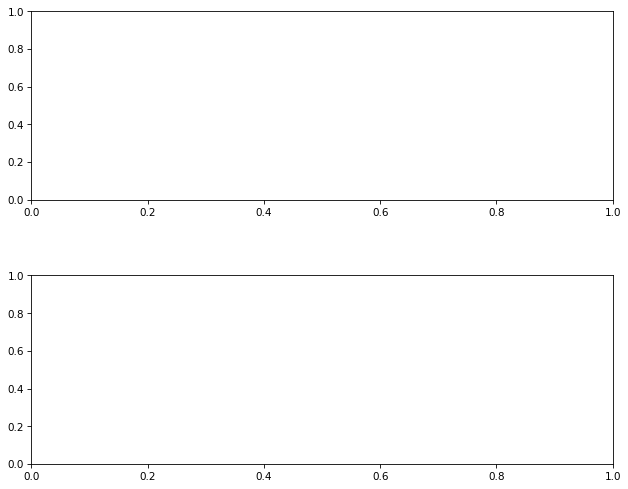

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=75)
fig.subplots_adjust(hspace=0.4)

cm_func = plt.get_cmap('nipy_spectral')
cm = cm_func(np.linspace(0, 0.95, Nants))

ax = axes[0]
ax.grid(True)
plabels = [ax.plot(times_xx, dly_xx[a], marker='.', c=cm[i], ms=5, ls='', alpha=0.75) for i, a in enumerate(ants)]
ax.set_xlabel('decimal of JD %d' % jd_start, fontsize=14)
ax.set_ylabel('delay solution [ns]', fontsize=14)
ax.set_title("FirstCal Delay Solutions for East Pol", fontsize=14)
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

ax = axes[1]
ax.grid(True)
plabels = [ax.plot(times_xx, fluc_xx[a], marker='.', c=cm[i], ms=5, ls='', alpha=0.5) for i, a in enumerate(ants)]
ax.set_xlabel('decimal of JD %d' % jd_start, fontsize=14)
ax.set_ylabel('delay fluctuation [ns]', fontsize=14)
ax.set_ylim(-2, 2)
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

ax = fig.add_axes([1.03, 0.1, 0.05, 0.8])
ax.axis('off')
ax.legend(np.concatenate(plabels), ants, ncol=2)

NameError: name 'Nants' is not defined

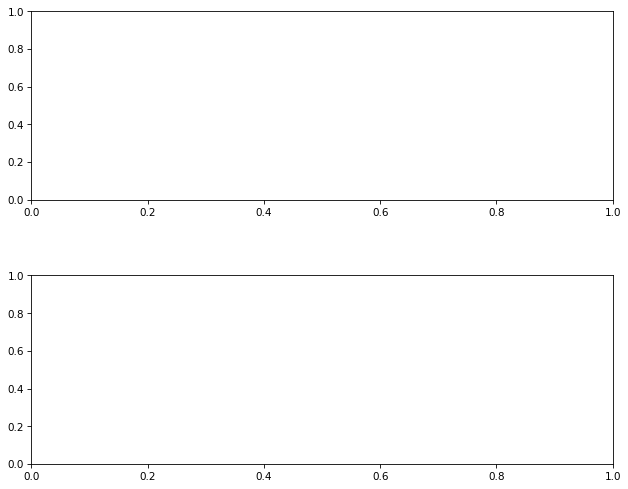

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=75)
fig.subplots_adjust(hspace=0.4)

cm_func = plt.get_cmap('nipy_spectral')
cm = cm_func(np.linspace(0, 0.95, Nants))

ax = axes[0]
ax.grid(True)
plabels = [ax.plot(times_yy, dly_yy[a], marker='.', c=cm[i], ms=5, ls='', alpha=0.75) for i, a in enumerate(ants)]
ax.set_xlabel('decimal of JD %d' % jd_start, fontsize=14)
ax.set_ylabel('delay solution [ns]', fontsize=14)
ax.set_title("FirstCal Delay Solutions for North Pol", fontsize=14)
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

ax = axes[1]
ax.grid(True)
plabels = [ax.plot(times_yy, fluc_yy[a], marker='.', c=cm[i], ms=5, ls='', alpha=0.5) for i, a in enumerate(ants)]
ax.set_xlabel('decimal of JD %d' % jd_start, fontsize=14)
ax.set_ylabel('delay fluctuation [ns]', fontsize=14)
ax.set_ylim(-2, 2)
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

ax = fig.add_axes([1.03, 0.1, 0.05, 0.8])
ax.axis('off')
ax.legend(np.concatenate(plabels), ants, ncol=2)

### collect `firstcal_metrics` over the observation

In [19]:
# append fc metrics across entire night
fc_met_xxfiles = map(lambda x: x + '.firstcal_metrics.json', fcfiles_xx)
fc_met_yyfiles = map(lambda x: x + '.firstcal_metrics.json', fcfiles_yy)

mets_xx = OrderedDict({'file_times':[],
                        'ant_dly_std':OrderedDict(map(lambda a: (a, []), ants)),
                        'good_sol':[],
                        'rot_ants':[]})
mets_yy = OrderedDict({'file_times':[],
                        'ant_dly_std':OrderedDict(map(lambda a: (a, []), ants)),
                        'good_sol':[],
                        'rot_ants':[]})

for i, (fc_met_xxfile, fc_met_yyfile) in enumerate(zip(fc_met_xxfiles, fc_met_yyfiles)):
    fc_xx_mets = hqm.firstcal_metrics.load_firstcal_metrics(fc_met_xxfile)
    fc_yy_mets = hqm.firstcal_metrics.load_firstcal_metrics(fc_met_yyfile)
    
    mets_xx['file_times'].append(float('.'.join(os.path.basename(fc_xx_mets['fc_filestem']).split('.')[1:3])) % jd_start)
    mets_xx['good_sol'].append(fc_xx_mets['good_sol'])
    mets_xx['rot_ants'].append(fc_xx_mets['rot_ants'])
    
    mets_yy['file_times'].append(float('.'.join(os.path.basename(fc_yy_mets['fc_filestem']).split('.')[1:3])) % jd_start)
    mets_yy['good_sol'].append(fc_yy_mets['good_sol'])
    mets_yy['rot_ants'].append(fc_yy_mets['rot_ants'])
    
    for a in ants:
        if a in fc_xx_mets['ants']:
            mets_xx['ant_dly_std'][a].append(fc_xx_mets['ant_std'][a])
        else:
            mets_xx['ant_dly_std'][a].append(np.nan)
        if a in fc_yy_mets['ants']:
            mets_yy['ant_dly_std'][a].append(fc_yy_mets['ant_std'][a])
        else:
            mets_yy['ant_dly_std'][a].append(np.nan)

NameError: name 'ants' is not defined

### get rotated antennas

In [20]:
print "detected XX rotated antennas: {}".format(np.unique(mets_xx['rot_ants']))
print "detected yy rotated antennas: {}".format(np.unique(mets_yy['rot_ants']))

NameError: name 'mets_xx' is not defined

### plot delay fluctuation standard deviation for each antenna per file

NameError: name 'ants' is not defined

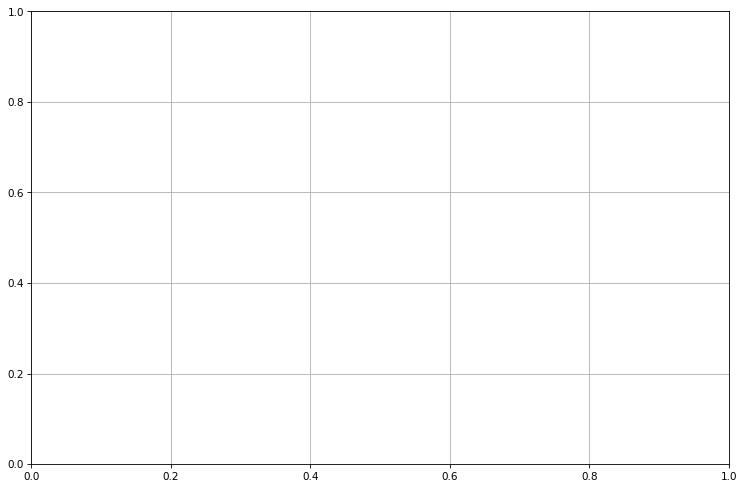

In [21]:
fig = plt.figure(figsize=(12,8), dpi=75)
ax = fig.add_subplot(111)
ax.grid(True)

# plotting
cm_func = plt.get_cmap('nipy_spectral')
cm = cm_func(np.linspace(0, 0.95, len(ants)))
p = map(lambda x: ax.plot(mets_xx['file_times'], x[1], marker='o', ls='-', c=cm[x[0]]), enumerate(np.array(mets_xx['ant_dly_std'].values())))

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_yticklabels()]
ax.set_xlabel('decimal of JD {}'.format(jd_start), fontsize=14)
ax.set_ylabel('standard deviation [nanosec]', fontsize=16)
ax.set_title("standard deviation of delay fluctuation per file for East pol", fontsize=14)
ax1 = fig.add_axes([1.03,0.1,0.05,0.8])
ax1.axis('off')
leg = ax1.legend(np.concatenate(p), ants, ncol=2)

NameError: name 'ants' is not defined

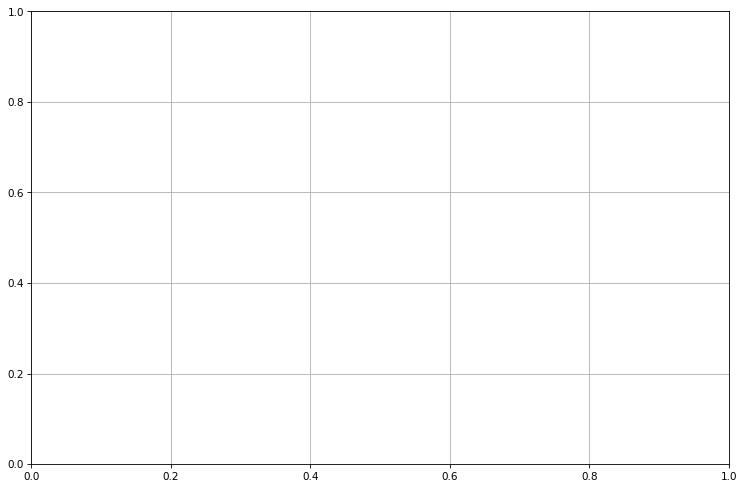

In [22]:
fig = plt.figure(figsize=(12,8), dpi=75)
ax = fig.add_subplot(111)
ax.grid(True)

# plotting
cm_func = plt.get_cmap('nipy_spectral')
cm = cm_func(np.linspace(0, 0.95, len(ants)))
p = map(lambda x: ax.plot(mets_yy['file_times'], x[1], marker='o', ls='-', c=cm[x[0]]), enumerate(np.array(mets_yy['ant_dly_std'].values())))

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_xticklabels()]
[t.set_fontsize(12) for t in ax.get_yticklabels()]
ax.set_xlabel('decimal of JD {}'.format(jd_start), fontsize=14)
ax.set_ylabel('standard deviation [nanosec]', fontsize=16)
ax.set_title("standard deviation of delay fluctuation per file for North pol", fontsize=14)
ax1 = fig.add_axes([1.03,0.1,0.05,0.8])
ax1.axis('off')
leg = ax1.legend(np.concatenate(p), ants, ncol=2)

### plot firstcal good / bad solution determination

Based on wheter the `max_std` of the delay fluctuations across all antennas is greater less or greater (good / bad) than `std_cut`, which is set to 0.5 nanoseconds by default.

NameError: name 'mets_xx' is not defined

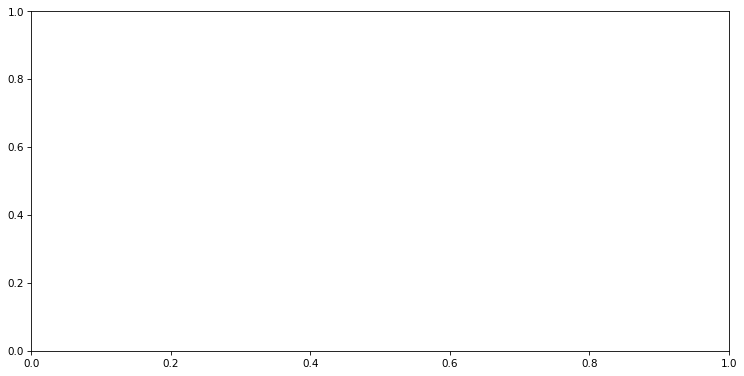

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 6), dpi=75)

p1, = ax.plot(mets_xx['file_times'], mets_xx['good_sol'], 'o', ms=5, color='steelblue')
p2, = ax.plot(mets_yy['file_times'], np.array(mets_yy['good_sol'], np.int)+.1, 'o', ms=5, color='darkorange')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_yticks([.05, 1.05])
ax.set_yticklabels(['bad solution', 'good solution'])
[t.set_size(14) for t in ax.get_yticklabels()]
[t.set_rotation(25) for t in ax.get_xticklabels()]
[t.set_size(14) for t in ax.get_xticklabels()]
ax.grid(True)
ax.legend([p1,p2], ["E pol", "N pol"], fontsize=14)
ax.set_xlabel('decimal of JD {}'.format(jd_start), fontsize=14)
ax.set_title("FirstCal solution goodness per file", fontsize=14)
ax.set_ylim(-0.2, 1.2)

## Omnical Solutions

In [24]:
# get files
def remove_pol(fname):
    fname = fname.split('.')
    fname.pop(3)
    return '.'.join(fname)

ocfiles = map(lambda x: os.path.join(data_path, x + '.omni.calfits'), map(remove_pol, xxfile_bases))
ocmetfiles = map(lambda x: x+'.omni_metrics.json', ocfiles)

fcfiles = []
for i, ocf in enumerate(ocfiles):
    fcfxx = ocf.split('/')[-1].split('.')
    fcfyy = ocf.split('/')[-1].split('.')
    fcfxx[5] = 'first'
    fcfyy[5] = 'first'
    fcfxx[2] += '.xx'
    fcfyy[2] += '.yy'
    fcfiles.append((os.path.join(data_path, '.'.join(fcfyy)), os.path.join(data_path, '.'.join(fcfxx))))

In [25]:
# get data
gain_xx = OrderedDict([(a, []) for a in ants])
gain_yy = OrderedDict([(a, []) for a in ants])
octimes = []
for i, f in enumerate(ocfiles):
    if os.path.isfile(f):
        octimes.append(float('.'.join(f.split('/')[-1].split('.')[1:3])))
        OM = hqm.omnical_metrics.OmniCal_Metrics(f)
        OM.load_firstcal_gains(fcfiles[i])
        for a in ants:
            if a in OM.ant_array:
                antindex = OM.ant_array.tolist().index(a)
                xxindex = OM.pols.tolist().index('XX')
                gain_xx[a].append(OM.gain_diff[antindex, 0, :, xxindex])
                yyindex = OM.pols.tolist().index('YY')
                gain_yy[a].append(OM.gain_diff[antindex, 0, :, yyindex])
            else:
                gain_xx[a].append(np.zeros(OM.Nfreqs)*np.nan)
                gain_yy[a].append(np.zeros(OM.Nfreqs)*np.nan)

N_ocfiles = len(octimes)

NameError: name 'ants' is not defined

### XX Antenna Gain Phase Solutions

In [26]:
Nside = int(np.ceil(np.sqrt(N_ocfiles)))
Yside = int(np.ceil(float(N_ocfiles)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(16,16), dpi=75)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle("omnical gain phase - firstcal gain phase solutions for East pol", fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

xlim = (-10, 1034)
ylim = (-np.pi, np.pi)
k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < N_ocfiles:
            p = [ax.plot(np.angle(gain_xx[a][k]), alpha=0.7, ls='', ms=0.3, marker='o') for a in ants]
            ax.grid(True)
            ax.set_title(str(octimes[k]), fontsize=10)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('gain phase [radians]', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
        k += 1
        
ax = fig.add_axes([.1, -.12, .8, .1])
p = np.concatenate([ax.plot([0], [0], marker='o', ls='') for a in ants])
ax.axis('off')
ax.legend(p, ants, ncol=len(ants)//4)
_ = [d.remove() for d in p]

NameError: name 'N_ocfiles' is not defined

### XX Antenna Gain Amp Solutions

In [27]:
Nside = int(np.ceil(np.sqrt(N_ocfiles)))
Yside = int(np.ceil(float(N_ocfiles)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(16,16), dpi=75)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle("omnical gain amp solutions for East pol", fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

xlim = (-10, 1034)
ylim = (0, 2)
k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < N_ocfiles:
            p = [ax.plot(np.abs(gain_xx[a][k]), alpha=0.7, ls='', ms=0.3, marker='o') for a in ants]
            ax.grid(True)
            ax.set_title(str(octimes[k]), fontsize=10)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('gain amplitude', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
        k += 1
        
ax = fig.add_axes([.1, -.12, .8, .1])
p = np.concatenate([ax.plot([0], [0], marker='o', ls='') for a in ants])
ax.axis('off')
ax.legend(p, ants, ncol=len(ants)//4)
_ = [d.remove() for d in p]

NameError: name 'N_ocfiles' is not defined

### YY Antenna Gain Phase Solutions

In [28]:
Nside = int(np.ceil(np.sqrt(N_ocfiles)))
Yside = int(np.ceil(float(N_ocfiles)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(16,16), dpi=75)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle("omnical gain phase - firstcal gain phase solutions for North pol", fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

xlim = (-10, 1034)
ylim = (-np.pi, np.pi)
k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < N_ocfiles:
            p = [ax.plot(np.angle(gain_yy[a][k]), alpha=0.7, ls='', ms=0.3, marker='o') for a in ants]
            ax.grid(True)
            ax.set_title(str(octimes[k]), fontsize=10)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(8) for t in ax.get_yticklabels()]
            ax.set_ylabel('gain phase [radians]', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(8) for t in ax.get_xticklabels()]
            [t.set_rotation(25) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
        k += 1
        
ax = fig.add_axes([.1, -.12, .8, .1])
p = np.concatenate([ax.plot([0], [0], marker='o', ls='') for a in ants])
ax.axis('off')
ax.legend(p, ants, ncol=len(ants)//4)
_ = [d.remove() for d in p]

NameError: name 'N_ocfiles' is not defined

### YY Omnical Gain Amp Solutions

In [29]:
Nside = int(np.ceil(np.sqrt(N_ocfiles)))
Yside = int(np.ceil(float(N_ocfiles)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(16,16), dpi=75)
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle("omnical gain amp solutions for North pol", fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

xlim = (-10, 1034)
ylim = (0, 2)
k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i,j]
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if k < N_ocfiles:
            p = [ax.plot(np.abs(gain_yy[a][k]), alpha=0.7, ls='', ms=0.3, marker='o') for a in ants]
            ax.grid(True)
            ax.set_title(str(octimes[k]), fontsize=10)
        else:
            ax.axis('off')
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('gain amp', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
        k += 1
        
ax = fig.add_axes([.1, -.12, .8, .1])
p = np.concatenate([ax.plot([0], [0], marker='o', ls='') for a in ants])
ax.axis('off')
ax.legend(p, ants, ncol=len(ants)//4)
_ = [d.remove() for d in p]

NameError: name 'N_ocfiles' is not defined

## Plot omni-applied visibilities w/ RFI flags

In [30]:
# load visibility data
uvd_xx = UVData()
uvd_xx.read_miriad(xxfile+'OR')
uvd_yy = UVData()
uvd_yy.read_miriad(yyfile+'OR')
uvd_ants = uvd_xx.antenna_numbers.tolist()
uvd_pos = uvd_xx.antenna_positions

NameError: name 'xxfile' is not defined

In [31]:
# get shortest E-W baseline group
bs_antnum_diff = np.array(map(lambda x: np.median(np.abs(map(lambda y: y[1] - y[0], x))), red_bls))
bl_group = np.concatenate(np.array(red_bls)[np.where(bs_antnum_diff < 1.5)[0]])
Nbls = len(bl_group)

# get reference bl
for bl in bl_group:
    if bl[0] in badants or bl[1] in badants:
        continue
    else:
        refbl = bl
        break

NameError: name 'red_bls' is not defined

### Amplitudes and Phases for XX

In [32]:
Nside = 3
Yside = int(np.ceil(float(Nbls)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14*float(Yside)/Nside), dpi=75)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle("Omnical Amplitude Waterfalls for East Pol & JD = {}".format(file_jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i, j]
        if k < Nbls:
            bl = bl_group[k]
            ax.matshow(np.log10(np.abs(uvd_xx.get_data(bl))), vmin=-3, vmax=2, aspect='auto')
            rfi_flags = uvd_xx.get_flags(bl).copy()
            rfi_flags = np.ma.masked_where(~rfi_flags, rfi_flags)
            ax.matshow(rfi_flags, cmap='bone_r', aspect='auto')
            ax.xaxis.set_ticks_position('bottom')
            ax.set_title("{}".format(bl_group[k]), fontsize=12, y=1.01)
        else:
            ax.axis('off')
            
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
            
        k += 1

NameError: name 'Nbls' is not defined

In [33]:
Nside = 3
Yside = int(np.ceil(float(Nbls)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14*float(Yside)/Nside), dpi=75)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle("Omnical Phase Waterfalls for East Pol & JD = {}".format(file_jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i, j]
        if k < Nbls:
            bl = bl_group[k]
            ax.matshow(np.angle(uvd_xx.get_data(bl)), vmin=-np.pi, vmax=np.pi, aspect='auto')
            rfi_flags = uvd_xx.get_flags(bl).copy()
            rfi_flags = np.ma.masked_where(~rfi_flags, rfi_flags)
            ax.matshow(rfi_flags, cmap='bone_r', aspect='auto')
            ax.xaxis.set_ticks_position('bottom')
            ax.set_title("{}".format(bl_group[k]), fontsize=12, y=1.01)
        else:
            ax.axis('off')
            
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
            
        k += 1

NameError: name 'Nbls' is not defined

### Amplitude and Phases for YY

In [34]:
Nside = 3
Yside = int(np.ceil(float(Nbls)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14*float(Yside)/Nside), dpi=75)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle("Omnical Amplitude Waterfalls for North Pol & JD = {}".format(file_jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i, j]
        if k < Nbls:
            bl = bl_group[k]
            ax.matshow(np.log10(np.abs(uvd_yy.get_data(bl))), vmin=-3, vmax=2, aspect='auto')
            rfi_flags = uvd_xx.get_flags(bl).copy()
            rfi_flags = np.ma.masked_where(~rfi_flags, rfi_flags)
            ax.matshow(rfi_flags, cmap='bone_r', aspect='auto')
            ax.xaxis.set_ticks_position('bottom')
            ax.set_title("{}".format(bl_group[k]), fontsize=12, y=1.01)
        else:
            ax.axis('off')
            
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
            
        k += 1

NameError: name 'Nbls' is not defined

In [35]:
Nside = 3
Yside = int(np.ceil(float(Nbls)/Nside))

fig, axes = plt.subplots(Yside, Nside, figsize=(14, 14*float(Yside)/Nside), dpi=75)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle("Omnical Phase Waterfalls for North Pol & JD = {}".format(file_jd), fontsize=14)
fig.tight_layout(rect=(0, 0, 1, 0.95))

k = 0
for i in range(Yside):
    for j in range(Nside):
        ax = axes[i, j]
        if k < Nbls:
            bl = bl_group[k]
            ax.matshow(np.angle(uvd_yy.get_data(bl)), vmin=-np.pi, vmax=np.pi, aspect='auto')
            rfi_flags = uvd_xx.get_flags(bl).copy()
            rfi_flags = np.ma.masked_where(~rfi_flags, rfi_flags)
            ax.matshow(rfi_flags, cmap='bone_r', aspect='auto')
            ax.xaxis.set_ticks_position('bottom')
            ax.set_title("{}".format(bl_group[k]), fontsize=12, y=1.01)
        else:
            ax.axis('off')
            
        if j != 0:
            ax.set_yticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_yticklabels()]
            ax.set_ylabel('time integrations', fontsize=10)
        if i != Yside-1:
            ax.set_xticklabels([])
        else:
            [t.set_fontsize(10) for t in ax.get_xticklabels()]
            ax.set_xlabel('freq channel', fontsize=10)
            
        k += 1

NameError: name 'Nbls' is not defined

## Omnical Metrics across the observation

In [36]:
# append chisq metric across entire night
full_mets_xx = OrderedDict({'times':[],
                            'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                            'chisq_avg':[]})
full_mets_yy = OrderedDict({'times':[],
                            'ant_phs_std_per_time':OrderedDict(map(lambda a: (a, []), ants)),
                            'chisq_avg':[]})

for i, xxf in enumerate(xxfile_bases):
    omnifile = xxf.split('.')
    omnifile.pop(3)
    omnifile = os.path.join(data_path, '.'.join(omnifile)+'.omni.calfits.omni_metrics.json')
    if os.path.isfile(omnifile) is False:
        continue
    omni_mets = hqm.omnical_metrics.load_omnical_metrics(omnifile)
    mets_xx = omni_mets['XX']
    mets_yy = omni_mets['YY']
    for a in ants:
        if a in mets_xx['ant_array']:
            full_mets_xx['ant_phs_std_per_time'][a].extend(mets_xx['ant_phs_std_per_time'][a])
        else:
            full_mets_xx['ant_phs_std_per_time'][a].extend(np.zeros(mets_xx['Ntimes']))
        if a in mets_yy['ant_array']:
            full_mets_yy['ant_phs_std_per_time'][a].extend(mets_yy['ant_phs_std_per_time'][a])
        else:
            full_mets_yy['ant_phs_std_per_time'][a].extend(np.zeros(mets_yy['Ntimes']))

    full_mets_xx['times'].extend(mets_xx['times'])
    full_mets_yy['times'].extend(mets_yy['times'])
    full_mets_xx['chisq_avg'].extend(mets_xx['chisq_avg'])
    full_mets_yy['chisq_avg'].extend(mets_yy['chisq_avg'])

NameError: name 'ants' is not defined

### standard deviation of XX & YY gain phases over observation

In [37]:
# plot each antenna gain phase stand dev over time
data = np.array(full_mets_xx['ant_phs_std_per_time'].values()).T

# figure
fig, ax = plt.subplots(1, figsize=(12,14), dpi=75)

# plotting
ymean = np.median(mets_xx['ant_phs_std'].values())
ysig = np.std(mets_xx['ant_phs_std'].values())
cax = ax.matshow(data, aspect='auto', cmap='Spectral_r', vmin=0, vmax=1.0,
                 extent=[0, Nants, full_mets_xx['times'][-1], full_mets_xx['times'][0]])

[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

# axes
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(Nants)+0.5)
ax.tick_params(size=8)
ax.set_xticklabels(ants)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_ylabel("time", fontsize=14)

ax.set_title("standard dev of firstcal-subtracted gain phase for East pol", fontsize=14)
cbar = fig.colorbar(cax, fraction=0.05)
cbar.set_label('gain phase std [radians]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

NameError: name 'full_mets_xx' is not defined

In [38]:
# plot each antenna gain phase stand dev over time
data = np.array(full_mets_yy['ant_phs_std_per_time'].values()).T

# figure
fig, ax = plt.subplots(1, figsize=(12,14), dpi=75)

# plotting
ymean = np.median(mets_yy['ant_phs_std'].values())
ysig = np.std(mets_yy['ant_phs_std'].values())
cax = ax.matshow(data, aspect='auto', cmap='Spectral_r', vmin=0, vmax=1.0,
                 extent=[0, Nants, full_mets_yy['times'][-1], full_mets_yy['times'][0]])

[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]

# axes
ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(Nants)+0.5)
ax.tick_params(size=8)
ax.set_xticklabels(ants)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_ylabel("time", fontsize=14)

ax.set_title("standard dev of firstcal-subtracted gain phase for North pol", fontsize=14)
cbar = fig.colorbar(cax, fraction=0.05)
cbar.set_label('gain phase std [radians]', fontsize=14)
cbar.ax.tick_params(labelsize=12)

NameError: name 'full_mets_yy' is not defined

### Plot averaged omnical Chi-Square over entire observation 

NameError: name 'full_mets_xx' is not defined

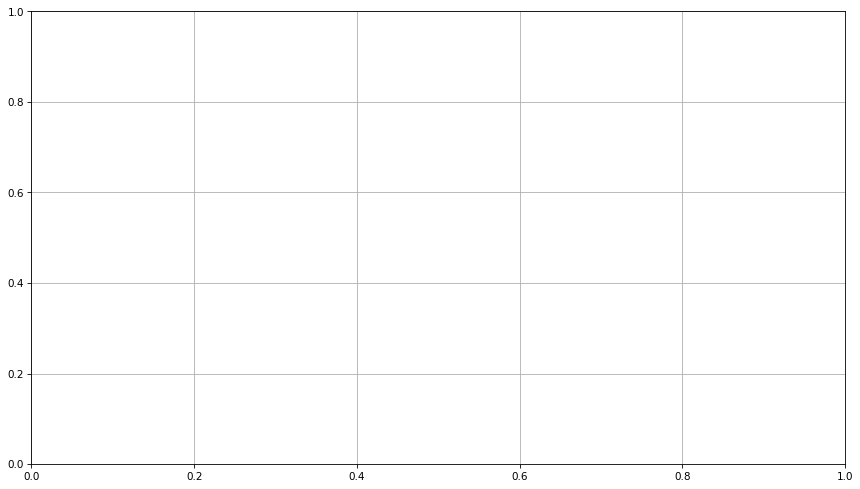

In [39]:
# figure
fig, ax = plt.subplots(1, figsize=(14,8), dpi=75)
ax.grid(True)

# plot
p1, = ax.plot(full_mets_xx['times']%jd_start, full_mets_xx['chisq_avg'], color='steelblue', alpha=0.5, ls='', ms=5, marker='o')
p2, = ax.plot(full_mets_yy['times']%jd_start, full_mets_yy['chisq_avg'], color='darkorange', alpha=0.5, ls='', ms=5, marker='o')
ax.legend([p1, p2], ['East', 'North'], fontsize=14)

# axes
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]
ax.tick_params(size=8)
ax.set_xlabel('decimal of JD = {}'.format(jd_start), fontsize=16)
ax.set_ylabel('average chi-square', fontsize=16)

### plot RFI summary info over observation

In [40]:
flags_xx_files = map(lambda x: x + 'O.flag_summary.npz', xxfiles)
flags_yy_files = map(lambda x: x + 'O.flag_summary.npz', yyfiles)

fmean_xx = []
fstd_xx = []
times_xx = []
tmean_xx = []

fmean_yy = []
fstd_yy = []
times_yy = []
tmean_yy = []

for i, fxx in enumerate(flags_xx_files):
    if os.path.isfile(fxx):
        arr = np.load(fxx)
        fmean_xx.extend(arr['fmean'].squeeze())
        fstd_xx.extend(arr['fstd'].squeeze())
        times_xx.extend(arr['times'])
        tmean_xx.append(arr['tmean'].squeeze())
for i, fyy in enumerate(flags_yy_files):
    if os.path.isfile(fyy):
        arr = np.load(fyy)
        fmean_yy.extend(arr['fmean'].squeeze())
        fstd_yy.extend(arr['fstd'].squeeze())
        times_yy.extend(arr['times'])
        tmean_yy.append(arr['tmean'].squeeze())

fmean_xx = np.array(fmean_xx)
fmean_yy = np.array(fmean_yy)
times_xx = np.array(times_xx)
times_yy = np.array(times_yy)
fstd_xx = np.array(fstd_xx)
fstd_yy = np.array(fstd_yy)
tmean_xx = np.mean(tmean_xx, axis=0)
tmean_yy = np.mean(tmean_yy, axis=0)

NameError: name 'jd_start' is not defined

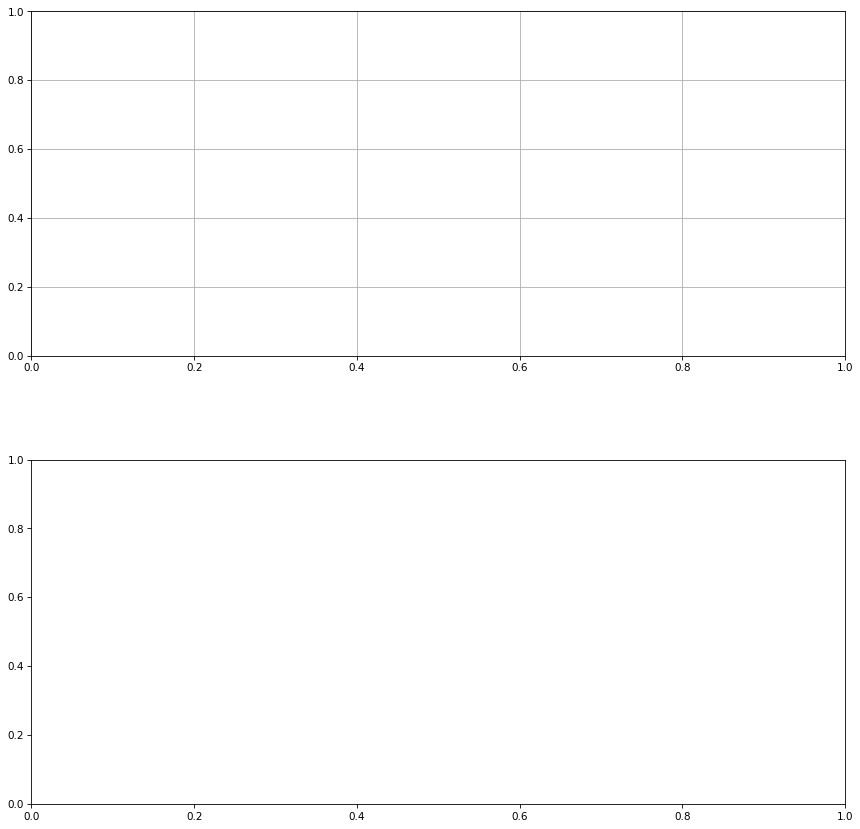

In [41]:
# figure
fig, axes = plt.subplots(2, 1, figsize=(14,14), dpi=75)
fig.subplots_adjust(hspace=0.3)

# fmean
ax = axes[0]
ax.grid(True)

# plot
p1, = ax.plot(times_xx % jd_start, fmean_xx, color='steelblue', alpha=0.5, ls='', ms=3, marker='o')
p2, = ax.plot(times_yy % jd_start, fmean_yy, color='darkorange', alpha=0.5, ls='', ms=3, marker='o')
ax.legend([p1, p2], ['East', 'North'], fontsize=14)

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]
ax.tick_params(size=8)
ax.set_xlabel('decimal of JD = {}'.format(jd_start), fontsize=16)
ax.set_ylabel("'fmean' flag summary", fontsize=16)

# fstd
ax = axes[1]
ax.grid(True)

# plot
p1, = ax.plot(times_xx % jd_start, fstd_xx, color='steelblue', alpha=0.5, ls='', ms=3, marker='o')
p2, = ax.plot(times_yy % jd_start, fstd_yy, color='darkorange', alpha=0.5, ls='', ms=3, marker='o')
ax.legend([p1, p2], ['East', 'North'], fontsize=14)

# axes
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
[t.set_rotation(20) for t in ax.get_xticklabels()]
[t.set_size(12) for t in ax.get_xticklabels()]
[t.set_rotation(20) for t in ax.get_yticklabels()]
[t.set_size(12) for t in ax.get_yticklabels()]
ax.tick_params(size=8)
ax.set_xlabel('decimal of JD = {}'.format(jd_start), fontsize=16)
ax.set_ylabel("'fstd' flag summary", fontsize=16)

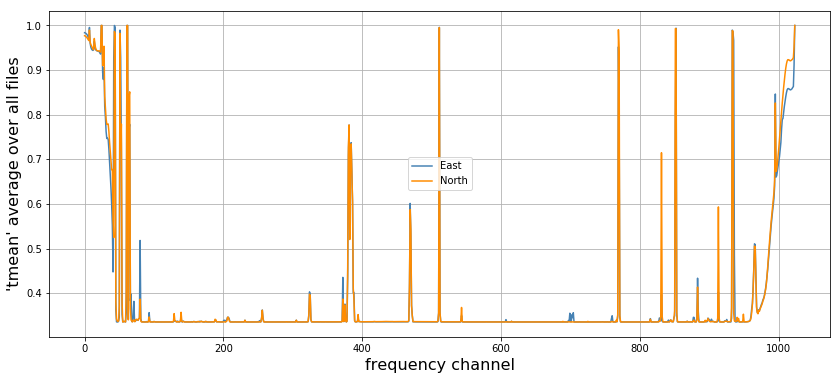

In [42]:
# figure
fig, ax = plt.subplots(1, figsize=(14, 6))

ax.grid()
ax.set_xlabel('frequency channel', fontsize=16)
ax.set_ylabel("'tmean' average over all files", fontsize=16)
p0, = ax.plot(tmean_xx, color='steelblue')
p1, = ax.plot(tmean_yy, color='darkorange')
ax.legend([p0, p1], ['East', 'North'])